# DRL Agent Training for Network Routing Optimization

## Overview
This notebook implements a complete Deep Reinforcement Learning (DRL) pipeline for training routing agents on network topologies from the dataset. The pipeline covers:
- Dataset loading and parsing
- Network simulator initialization
- RL environment definition
- DRL agent implementation
- Training loop
- Evaluation and analysis

## Section 1: Dataset Preparation and Loading

Load and parse network topologies from the dataset files. Extract node and edge attributes including link capacities, delays, and QoS parameters.

In [1]:

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive")
import importlib.util
spec = importlib.util.find_spec("network_topology_pkg")
print(spec)
from network_topology_pkg.core import NetworkTopology, NodeAttributes, LinkAttributes
from network_topology_pkg.analyzer import TopologyAnalyzer
from network_topology_pkg.builder import TopologyBuilder

Mounted at /content/drive
ModuleSpec(name='network_topology_pkg', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7a4ae718e030>, origin='/content/drive/MyDrive/network_topology_pkg/__init__.py', submodule_search_locations=['/content/drive/MyDrive/network_topology_pkg'])


In [2]:
import sys
import os

# Add the project directory to path


import numpy as np
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import json
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import custom NetworkTopology package - direct imports from modules
try:
    from network_topology_pkg.core import NetworkTopology, NodeAttributes, LinkAttributes
    from network_topology_pkg.analyzer import TopologyAnalyzer
    from network_topology_pkg.builder import TopologyBuilder
    print("✓ All network_topology_pkg modules imported successfully")
except ImportError as e:
    print(f"❌ Failed to import from network_topology_pkg: {e}")
    print("\nDebug info:")
    print(f"  Current directory: {os.getcwd()}")
    print(f"  sys.path includes: {project_dir}")
    print(f"  Package directory exists: {Path(project_dir) / 'network_topology_pkg'}")
    print(f"  Contents: {list((Path(project_dir) / 'network_topology_pkg').glob('*.py'))}")
    raise

print("✓ All imports successful")

✓ All network_topology_pkg modules imported successfully
✓ All imports successful


In [3]:
class GraphFileParser:
    """Parse graph files in GML-like format from the dataset."""

    @staticmethod
    def parse_graph_file(filepath: str) -> Tuple[Dict, List]:
        """
        Parse a graph file and extract nodes and edges.

        Args:
            filepath: Path to the graph file

        Returns:
            Tuple of (nodes_dict, edges_list)
        """
        nodes = {}
        edges = []

        with open(filepath, 'r') as f:
            lines = f.readlines()

        content = ''.join(lines)

        # Parse nodes
        node_pattern = r'node\s*\[\s*(.*?)\s*\]'
        for node_match in re.finditer(node_pattern, content, re.DOTALL):
            node_content = node_match.group(1)
            node_data = GraphFileParser._parse_attributes(node_content)
            node_id = int(node_data.get('id', -1))
            nodes[node_id] = node_data

        # Parse edges
        edge_pattern = r'edge\s*\[\s*(.*?)\s*\]'
        for edge_match in re.finditer(edge_pattern, content, re.DOTALL):
            edge_content = edge_match.group(1)
            edge_data = GraphFileParser._parse_attributes(edge_content)
            edges.append(edge_data)

        return nodes, edges

    @staticmethod
    def _parse_attributes(content: str) -> Dict:
        """Parse attributes from node/edge content."""
        attributes = {}

        # Split by lines and process each
        lines = content.strip().split('\n')

        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Handle quoted values
            if '"' in line:
                match = re.match(r'(\w+)\s+"([^"]*)"', line)
                if match:
                    key, value = match.groups()
                    attributes[key] = value
                    continue

            # Handle unquoted values
            match = re.match(r'(\w+)\s+(\S+)', line)
            if match:
                key, value = match.groups()
                # Try to convert to number
                try:
                    if '.' in value:
                        attributes[key] = float(value)
                    else:
                        attributes[key] = int(value)
                except ValueError:
                    attributes[key] = value

        return attributes

# Test parser on sample file
dataset_path = Path("/content/drive/MyDrive/gnnet_data_set_training/graphs")

sample_file = list(dataset_path.glob('*.txt'))[0]

print(f"Loading sample graph: {sample_file.name}")
nodes, edges = GraphFileParser.parse_graph_file(str(sample_file))

print(f"\n✓ Parsed {len(nodes)} nodes and {len(edges)} edges")
print(f"\nSample node (ID 0):")
print(json.dumps(nodes[0], indent=2))
print(f"\nSample edge:")
print(json.dumps(edges[0], indent=2))

Loading sample graph: graph-nsfnet-wfq-10.txt

✓ Parsed 14 nodes and 42 edges

Sample node (ID 0):
{
  "id": 0,
  "label": "0",
  "schedulingPolicy": "WFQ",
  "schedulingWeights": "75,25,5",
  "queueSizes": "32,32,32",
  "levelsQoS": "3"
}

Sample edge:
{
  "source": 0,
  "target": 1,
  "key": 0,
  "port": 0,
  "weight": 1,
  "bandwidth": "10000"
}


In [4]:
def load_network_topology(graph_file: str) -> NetworkTopology:
    """
    Load network topology from graph file into NetworkTopology object.

    Args:
        graph_file: Path to graph file

    Returns:
        NetworkTopology object with loaded nodes and edges
    """
    nodes, edges = GraphFileParser.parse_graph_file(graph_file)
    topology = NetworkTopology()

    # Add nodes with processing delay (default 1.0 ms)
    for node_id, node_data in nodes.items():
        processing_delay = float(node_data.get('processingDelay', 1.0))
        topology.add_node(str(node_id), processing_delay=processing_delay)

    # Add edges with bandwidth (convert from kbps to Mbps)
    edges_added = 0
    for edge_data in edges:
        src = str(edge_data.get('source'))
        dst = str(edge_data.get('target'))

        if src in topology.node_attributes and dst in topology.node_attributes:
            bandwidth_kbps = float(edge_data.get('bandwidth', 1000))
            bandwidth_mbps = bandwidth_kbps / 1000.0

            try:
                topology.add_link(
                    source_node=src,
                    dest_node=dst,
                    capacity=bandwidth_mbps,
                    propagation_delay=1.0,  # Default 1ms
                    queue_size=100,         # Default queue size
                    loss_probability=0.0
                )
                edges_added += 1
            except RuntimeError:
                # Link already exists (multigraph case)
                pass

    return topology, edges_added


# Load ALL topologies from dataset for full training
print("Loading ALL network topologies from dataset...")
print("This may take a moment (loading 400+ topologies)...\n")
topology_files = sorted(list(dataset_path.glob('*.txt')))  # Load ALL topologies
topologies = {}
failed_count = 0

for idx, topo_file in enumerate(topology_files):
    try:
        if (idx + 1) % 50 == 0:
            print(f"  Progress: {idx+1}/{len(topology_files)} topologies loaded...")

        topo_name = topo_file.stem
        topology, edges_count = load_network_topology(str(topo_file))

        if edges_count > 0:  # Only keep topologies with edges
            topologies[topo_name] = topology
        else:
            failed_count += 1
    except Exception as e:
        failed_count += 1

print(f"\n✓ Successfully loaded {len(topologies)} valid topologies")
if failed_count > 0:
    print(f"⚠ Failed to load {failed_count} topologies (no edges or parsing error)")
print(f"Total topologies available for training: {len(topologies)}")

Loading ALL network topologies from dataset...
This may take a moment (loading 400+ topologies)...

  Progress: 50/402 topologies loaded...
  Progress: 100/402 topologies loaded...
  Progress: 150/402 topologies loaded...
  Progress: 200/402 topologies loaded...
  Progress: 250/402 topologies loaded...
  Progress: 300/402 topologies loaded...
  Progress: 350/402 topologies loaded...
  Progress: 400/402 topologies loaded...

✓ Successfully loaded 402 valid topologies
Total topologies available for training: 402


## Section 3: State and Action Definition

Define the RL environment state representation and action space for routing decisions.

In [5]:
class NetworkSimulator:
    """Simulates network packet forwarding and QoS metrics."""

    def __init__(self, topology: NetworkTopology):
        """
        Initialize simulator with network topology.

        Args:
            topology: NetworkTopology object
        """
        self.topology = topology
        self.link_loads = {}  # Link utilization tracking
        self.link_queues = {}  # Queue lengths per link
        self.flow_delays = defaultdict(list)

        # Initialize link states
        for link in topology.get_all_links():
            self.link_loads[link] = 0.0
            self.link_queues[link] = 0

    def reset(self):
        """Reset simulator state."""
        self.link_loads = {link: 0.0 for link in self.topology.get_all_links()}
        self.link_queues = {link: 0 for link in self.topology.get_all_links()}
        self.flow_delays = defaultdict(list)

    def generate_traffic_demand(self, num_flows: int = 10) -> List[Dict]:
        """
        Generate random traffic demands (src, dst, volume).

        Args:
            num_flows: Number of flows to generate

        Returns:
            List of flow demands
        """
        nodes = self.topology.get_all_nodes()
        demands = []

        for _ in range(num_flows):
            if len(nodes) < 2:
                break

            src, dst = np.random.choice(nodes, 2, replace=False)
            volume = np.random.uniform(10, 1000)  # Mbps
            priority = np.random.randint(0, 3)    # QoS priority (0-2)

            demands.append({
                'src': src,
                'dst': dst,
                'volume': volume,
                'priority': priority
            })

        return demands

    def route_flow(self, flow: Dict, routing_action: int) -> Tuple[List[str], float]:
        """
        Route a flow based on action and compute delay.

        Args:
            flow: Flow demand
            routing_action: Action index (0=shortest hop, 1=low-delay, 2=high-capacity)

        Returns:
            Tuple of (path, total_delay)
        """
        src, dst = flow['src'], flow['dst']

        # Check if source and destination are the same
        if src == dst:
            return [src], 0.0

        try:
            if routing_action == 0:
                # Shortest hop count path
                path = self.topology.get_shortest_path(src, dst, weight=None)
            elif routing_action == 1:
                # Minimum delay path
                try:
                    path = self.topology.get_shortest_path(src, dst, weight='propagation_delay')
                except nx.NetworkXNoPath:
                    # Fall back to shortest hop if weighted path fails
                    path = self.topology.get_shortest_path(src, dst, weight=None)
            else:
                # Maximum capacity path
                try:
                    path = self.topology.get_shortest_path(src, dst, weight='capacity')
                except nx.NetworkXNoPath:
                    # Fall back to shortest hop if weighted path fails
                    path = self.topology.get_shortest_path(src, dst, weight=None)

            # Calculate path delay
            total_delay = 0.0
            for i in range(len(path) - 1):
                link = (path[i], path[i + 1])
                attrs = self.topology.get_link_attributes(path[i], path[i + 1])
                # Add propagation delay + queue delay
                queue_delay = self.link_queues.get(link, 0) * 0.1  # 0.1ms per packet
                total_delay += attrs['propagation_delay'] + queue_delay

            return path, total_delay

        except (nx.NetworkXNoPath, ValueError) as e:
            # No path exists - return empty path with high penalty
            return [], float('inf')

    def forward_flow(self, flow: Dict, path: List[str]):
        """
        Forward flow along path and update link states.

        Args:
            flow: Flow demand
            path: Routing path
        """
        if not path or len(path) < 2:
            return

        volume = flow['volume']

        for i in range(len(path) - 1):
            link = (path[i], path[i + 1])
            if link in self.link_loads:
                self.link_loads[link] += volume
                self.link_queues[link] += int(volume / 10)  # Rough queue estimate

### Section 4: Network Simulator

Implements the network simulator that tracks link utilization, queue lengths, and flow delays. The simulator computes packet forwarding delays based on the selected routing action (shortest hop, minimum delay, or maximum capacity) and updates network state accordingly.

In [6]:
class RLEnvironment:
    """RL Environment for network routing optimization."""

    def __init__(self, topology: NetworkTopology, simulator: NetworkSimulator):
        """
        Initialize RL environment.

        Args:
            topology: NetworkTopology object
            simulator: NetworkSimulator object
        """
        self.topology = topology
        self.simulator = simulator
        self.action_space_size = 3  # 3 routing actions
        self.max_steps = 50

        self.nodes = sorted(topology.get_all_nodes())
        self.node_to_idx = {node: idx for idx, node in enumerate(self.nodes)}
        self.edges = topology.get_all_links()
        self.edge_index = self._build_edge_index()

        # Initialize flows immediately
        self.current_flows = simulator.generate_traffic_demand(num_flows=5)
        self.flow_count = 0
        self.no_path_count = 0
        self.current_step = 0

    def _build_edge_index(self) -> torch.Tensor:
        """Build edge index tensor for GNN."""
        edge_list = []
        for src, dst in self.edges:
            if src in self.node_to_idx and dst in self.node_to_idx:
                src_idx = self.node_to_idx[src]
                dst_idx = self.node_to_idx[dst]
                edge_list.append([src_idx, dst_idx])

        if edge_list:
            return torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        else:
            return torch.zeros((2, 0), dtype=torch.long)

    def reset(self) -> Tuple[torch.Tensor, np.ndarray, torch.Tensor]:
        """
        Reset environment for new episode.

        Returns:
            Tuple of (node_features, flow_state, edge_index)
        """
        self.simulator.reset()
        self.current_flows = self.simulator.generate_traffic_demand(num_flows=5)
        self.flow_count = 0
        self.no_path_count = 0
        self.current_step = 0

        node_features = self._get_node_features()
        flow_state = self._get_flow_state()
        edge_index = self.edge_index

        return node_features, flow_state, edge_index

    def _get_node_features(self) -> torch.Tensor:
        """Get node feature matrix for GNN."""
        node_features = []
        for node in self.nodes:
            load = sum(self.simulator.link_loads.get((node, n), 0) for n in self.nodes
                      if (node, n) in self.simulator.link_loads)
            queue = sum(self.simulator.link_queues.get((node, n), 0) for n in self.nodes
                       if (node, n) in self.simulator.link_queues)
            node_features.append([load / 1000.0, queue / 100.0])

        return torch.tensor(node_features, dtype=torch.float32)

    def _get_graph_state(self) -> np.ndarray:
        """Get graph state representation."""
        num_nodes = len(self.topology.get_all_nodes())
        num_links = len(self.topology.get_all_links())

        # State: [num_nodes, num_links, avg_load, max_load]
        loads = list(self.simulator.link_loads.values())
        avg_load = np.mean(loads) if loads else 0.0
        max_load = np.max(loads) if loads else 0.0

        return np.array([num_nodes, num_links, avg_load, max_load], dtype=np.float32)

    def _get_flow_state(self) -> np.ndarray:
        """Get flow state representation."""
        # Handle case where flows list is empty
        if not self.current_flows:
            # Return a default state
            num_nodes = len(self.topology.get_all_nodes())
            return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)

        if self.flow_count >= len(self.current_flows):
            self.flow_count = 0

        flow = self.current_flows[self.flow_count]

        # Convert node IDs to indices
        nodes = sorted(self.topology.get_all_nodes())
        src_idx = nodes.index(flow['src']) if flow['src'] in nodes else 0
        dst_idx = nodes.index(flow['dst']) if flow['dst'] in nodes else 0

        # State: [src_idx, dst_idx, volume, priority, avg_load, congestion]
        loads = list(self.simulator.link_loads.values())
        avg_load = np.mean(loads) if loads else 0.0
        congestion = len([l for l in loads if l > 500]) / len(loads) if loads else 0.0

        state = np.array([
            src_idx / max(len(nodes), 1),
            dst_idx / max(len(nodes), 1),
            flow['volume'] / 1000.0,
            flow['priority'] / 2.0,
            avg_load / 1000.0,
            congestion
        ], dtype=np.float32)

        return state

    def step(self, action: int) -> Tuple[Tuple[torch.Tensor, np.ndarray, torch.Tensor], float, bool]:
        """
        Execute one environment step.

        Args:
            action: Routing action (0, 1, or 2)

        Returns:
            Tuple of ((node_features, flow_state, edge_index), reward, done)
        """
        flow = self.current_flows[self.flow_count]

        # Route flow
        path, delay = self.simulator.route_flow(flow, action)

        # Compute reward
        reward = self._compute_reward(delay, path)

        # Forward flow
        self.simulator.forward_flow(flow, path)

        self.flow_count += 1
        self.current_step += 1

        done = self.current_step >= self.max_steps

        node_features = self._get_node_features()
        flow_state = self._get_flow_state()
        edge_index = self.edge_index

        return (node_features, flow_state, edge_index), reward, done

    def _compute_reward(self, delay: float, path: List[str]) -> float:
        """
        Compute reward based on QoS metrics.

        Args:
            delay: Path delay
            path: Routing path

        Returns:
            Reward value
        """
        if not path or len(path) < 2:
            self.no_path_count += 1
            return -0.15

        success_bonus = 0.05
        delay_normalized = min(max(delay, 0) / 500.0, 1.0)
        delay_penalty = -0.025 * delay_normalized

        load_penalty = 0.0
        if len(path) > 1:
            total_load = 0
            for i in range(len(path) - 1):
                link = (path[i], path[i + 1])
                load = self.simulator.link_loads.get(link, 0)
                total_load += load

            avg_load = total_load / len(path)
            if avg_load > 300:
                load_normalized = min((avg_load - 300) / 700.0, 1.0)
                load_penalty = -0.015 * load_normalized

        path_efficiency = 0.01 if len(path) <= 4 else 0.005

        return success_bonus + delay_penalty + load_penalty + path_efficiency

### Section 5: RL Environment

Defines the RL environment that bridges the network simulator and the agent. It provides graph structure data (node features and edge indices), flow state representations, and computes rewards based on QoS metrics including delay, packet loss, and load balancing. The environment manages the interaction loop between agent actions and network state transitions.

In [7]:
class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, edge_index):
        edge_index_np = edge_index.cpu().numpy()
        row, col = edge_index_np[0], edge_index_np[1]
        num_nodes = x.size(0)

        adj = torch.zeros((num_nodes, num_nodes), device=x.device)
        for i, j in zip(row, col):
            adj[i, j] = 1.0

        degree = adj.sum(dim=1).clamp(min=1.0)
        deg_inv_sqrt = degree.pow(-0.5)

        x = torch.matmul(x, self.weight) + self.bias
        x = torch.matmul(deg_inv_sqrt.unsqueeze(1) * adj, x)
        x = x * deg_inv_sqrt.unsqueeze(1)

        return x


class GNNAgent(nn.Module):
    def __init__(self, node_feature_dim: int, hidden_dim: int,
                 action_space_size: int, learning_rate: float = 0.001):
        super(GNNAgent, self).__init__()
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate

        self.gcn1 = GCNLayer(node_feature_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim)

        self.policy_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size)
        )

        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.flow_encoder = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, hidden_dim)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        self.experience_buffer = {
            'node_features': [],
            'flow_states': [],
            'edge_indices': [],
            'actions': [],
            'rewards': [],
            'next_node_features': [],
            'next_flow_states': [],
            'next_edge_indices': [],
            'dones': []
        }

        self.episode_rewards = []
        self.episode_actions = []

    def forward(self, node_features, edge_index, flow_state):
        x = F.relu(self.gcn1(node_features, edge_index))
        x = F.relu(self.gcn2(x, edge_index))

        graph_embedding = x.mean(dim=0)
        flow_embedding = self.flow_encoder(flow_state.to(self.device))

        combined = graph_embedding + flow_embedding

        policy_logits = self.policy_head(combined)
        value = self.value_head(combined)

        return policy_logits, value

    def select_action(self, node_features, edge_index, flow_state, epsilon: float = 0.1) -> int:
        with torch.no_grad():
            node_features = node_features.to(self.device)
            edge_index = edge_index.to(self.device)
            flow_state_tensor = torch.tensor(flow_state, dtype=torch.float32)

            policy_logits, _ = self.forward(node_features, edge_index, flow_state_tensor)
            probabilities = F.softmax(policy_logits, dim=0)

        if np.random.random() < epsilon:
            action = np.random.randint(self.action_space_size)
        else:
            action = probabilities.argmax().item()

        self.episode_actions.append(action)
        return action

    def store_experience(self, node_features, flow_state, edge_index, action: int,
                        reward: float, next_node_features, next_flow_state,
                        next_edge_index, done: bool):
        self.experience_buffer['node_features'].append(node_features)
        self.experience_buffer['flow_states'].append(flow_state)
        self.experience_buffer['edge_indices'].append(edge_index)
        self.experience_buffer['actions'].append(action)
        self.experience_buffer['rewards'].append(reward)
        self.experience_buffer['next_node_features'].append(next_node_features)
        self.experience_buffer['next_flow_states'].append(next_flow_state)
        self.experience_buffer['next_edge_indices'].append(next_edge_index)
        self.experience_buffer['dones'].append(done)

    def update_policy(self, batch_size: int = 32, gamma: float = 0.99):
        if len(self.experience_buffer['actions']) < batch_size:
            return

        indices = np.random.choice(len(self.experience_buffer['actions']),
                                   batch_size, replace=False)

        policy_losses = []
        value_losses = []

        for idx in indices:
            node_features = self.experience_buffer['node_features'][idx].to(self.device)
            flow_state = torch.tensor(self.experience_buffer['flow_states'][idx], dtype=torch.float32)
            edge_index = self.experience_buffer['edge_indices'][idx].to(self.device)
            action = self.experience_buffer['actions'][idx]
            reward = self.experience_buffer['rewards'][idx]
            next_node_features = self.experience_buffer['next_node_features'][idx].to(self.device)
            next_flow_state = torch.tensor(self.experience_buffer['next_flow_states'][idx], dtype=torch.float32)
            next_edge_index = self.experience_buffer['next_edge_indices'][idx].to(self.device)
            done = self.experience_buffer['dones'][idx]

            with torch.no_grad():
                _, next_value = self.forward(next_node_features, next_edge_index, next_flow_state)
                next_value = next_value.item() if not done else 0.0
                td_target = reward + gamma * next_value

            policy_logits, value = self.forward(node_features, edge_index, flow_state)
            value = value.squeeze()

            value_loss = F.mse_loss(value, torch.tensor(td_target, dtype=torch.float32))
            policy_loss = -F.log_softmax(policy_logits, dim=0)[action]

            policy_losses.append(policy_loss)
            value_losses.append(value_loss)

        total_loss = torch.stack(policy_losses).mean() + torch.stack(value_losses).mean()

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

    def record_episode(self, episode_reward: float):
        self.episode_rewards.append(episode_reward)


# Initialize environment with first topology
if len(topologies) > 0:
    first_topology = list(topologies.values())[0]
    simulator = NetworkSimulator(first_topology)
    env = RLEnvironment(first_topology, simulator)
    print(f"✓ Environment initialized with topology: {list(topologies.keys())[0]}")
    print(f"  Nodes: {len(first_topology.get_all_nodes())}")
    print(f"  Links: {len(first_topology.get_all_links())}")
    print(f"  Action space size: {env.action_space_size}")
else:
    raise ValueError("No topologies loaded. Check dataset loading.")

# Initialize GNN agent
node_feature_dim = 2
hidden_dim = 32
agent = GNNAgent(node_feature_dim=node_feature_dim,
                 hidden_dim=hidden_dim,
                 action_space_size=env.action_space_size,
                 learning_rate=0.001)

print(f"✓ GNN Agent initialized")
print(f"  GCN layers: {node_feature_dim} -> {hidden_dim} -> {hidden_dim}")
print(f"  Policy head: {hidden_dim} -> 64 -> {env.action_space_size}")
print(f"  Value head: {hidden_dim} -> 64 -> 1")
print(f"  Device: {agent.device}")

✓ Environment initialized with topology: graph-geant2-wfq-0
  Nodes: 24
  Links: 74
  Action space size: 3
✓ GNN Agent initialized
  GCN layers: 2 -> 32 -> 32
  Policy head: 32 -> 64 -> 3
  Value head: 32 -> 64 -> 1
  Device: cpu


### Section 6: GNN Agent Implementation

Implements a Graph Neural Network (GNN) based agent using Graph Convolutional Networks (GCN). The agent processes network topology as a graph with node features and edge indices, encodes flow requirements, and outputs policy logits for routing action selection. This section includes the GCN layer implementation, policy/value heads, and experience replay buffer management.

In [8]:
# GPU Configuration
import torch
import json
from datetime import datetime

# Detect GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*60}")
print(f"GPU Configuration")
print(f"{'='*60}")
if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(f"✗ No GPU available, using CPU")
    device = torch.device('cpu')

print(f"{'='*60}\n")

# Training configuration for full dataset
NUM_EPISODES = 500  # Increased from 20 for full dataset training
MAX_STEPS_PER_EPISODE = 100  # Increased from 50 for longer episodes
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.99
BATCH_SIZE = 32
EPSILON_START = 0.3
EPSILON_END = 0.01
UPDATE_FREQUENCY = 10
SAVE_FREQUENCY = 50  # Save model every 50 episodes
MODEL_SAVE_PATH = '/tmp/drl_agent_checkpoint.pt'

epsilon = EPSILON_START
training_history = {
    'episode': [],
    'reward': [],
    'avg_reward': [],
    'topology_index': []
}

print(f"Training Configuration:")
print(f"  Episodes: {NUM_EPISODES}")
print(f"  Steps per episode: {MAX_STEPS_PER_EPISODE}")
print(f"  Topologies to train on: {len(topologies)}")
print(f"  Epsilon decay: {EPSILON_START:.3f} -> {EPSILON_END:.3f}")
print(f"  Device: {device}")
print("-" * 60)

# Create list of topologies for cycling through training
topo_list = list(topologies.items())
current_topo_idx = 0

print(f"\nStarting training on {len(topologies)} topologies...")

for episode in range(NUM_EPISODES):
    # Cycle through different topologies for better generalization
    topo_name, current_topology = topo_list[current_topo_idx % len(topo_list)]
    current_topo_idx += 1

    # Create environment for current topology
    env = RLEnvironment(current_topology, NetworkSimulator(current_topology))
    env.max_steps = MAX_STEPS_PER_EPISODE

    # Reset for new episode
    node_features, flow_state, edge_index = env.reset()
    episode_reward = 0.0
    epsilon = EPSILON_START - (EPSILON_START - EPSILON_END) * (episode / NUM_EPISODES)

    for step in range(MAX_STEPS_PER_EPISODE):
        # Agent selects action
        action = agent.select_action(node_features, edge_index, flow_state, epsilon=epsilon)

        # Environment step
        (next_node_features, next_flow, next_edge_index), reward, done = env.step(action)

        # Store experience
        agent.store_experience(node_features, flow_state, edge_index, action, reward,
                              next_node_features, next_flow, next_edge_index, done)

        episode_reward += reward
        node_features, flow_state = next_node_features, next_flow

        if done:
            break

    # Update policy
    if (episode + 1) % UPDATE_FREQUENCY == 0:
        agent.update_policy(batch_size=BATCH_SIZE)

    # Record metrics
    agent.record_episode(episode_reward)
    avg_reward = np.mean(agent.episode_rewards[-10:])

    training_history['episode'].append(episode + 1)
    training_history['reward'].append(episode_reward)
    training_history['avg_reward'].append(avg_reward)
    training_history['topology_index'].append(current_topo_idx % len(topo_list))

    # Print progress
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1:3d}/{NUM_EPISODES} | Reward: {episode_reward:7.3f} | "
              f"Avg (last 10): {avg_reward:7.3f} | Epsilon: {epsilon:.3f} | "
              f"Topo: {current_topo_idx % len(topo_list)}/{len(topo_list)}")

    # Save checkpoint
    if (episode + 1) % SAVE_FREQUENCY == 0:
        torch.save({
            'episode': episode + 1,
            'agent_state': agent.state_dict(),
            'training_history': training_history
        }, MODEL_SAVE_PATH)
        print(f"  ✓ Checkpoint saved at episode {episode + 1}")

print("-" * 60)
print("✓ Training completed")
print(f"  Final average reward: {training_history['avg_reward'][-1]:.3f}")
print(f"  Best episode reward: {max(training_history['reward']):.3f}")
print(f"  Total episodes trained: {NUM_EPISODES}")
print(f"  Total topologies used: {len(topo_list)}")


GPU Configuration
✗ No GPU available, using CPU

Training Configuration:
  Episodes: 500
  Steps per episode: 100
  Topologies to train on: 402
  Epsilon decay: 0.300 -> 0.010
  Device: cpu
------------------------------------------------------------

Starting training on 402 topologies...
Episode  50/500 | Reward:   4.056 | Avg (last 10):   3.974 | Epsilon: 0.272 | Topo: 50/402
  ✓ Checkpoint saved at episode 50
Episode 100/500 | Reward:   3.897 | Avg (last 10):   3.963 | Epsilon: 0.243 | Topo: 100/402
  ✓ Checkpoint saved at episode 100
Episode 150/500 | Reward:   3.969 | Avg (last 10):   3.710 | Epsilon: 0.214 | Topo: 150/402
  ✓ Checkpoint saved at episode 150
Episode 200/500 | Reward:   3.786 | Avg (last 10):   3.883 | Epsilon: 0.185 | Topo: 200/402
  ✓ Checkpoint saved at episode 200
Episode 250/500 | Reward:   4.389 | Avg (last 10):   4.250 | Epsilon: 0.156 | Topo: 250/402
  ✓ Checkpoint saved at episode 250
Episode 300/500 | Reward:   4.378 | Avg (last 10):   4.198 | Epsilon: 

### Section 7: Training Loop

The main training loop where the GNN agent learns routing policies across 500 episodes on 400+ network topologies. The agent cycles through topologies sequentially, executes episodes with epsilon-greedy exploration, stores experiences in the replay buffer, and updates the policy using backpropagation through the GCN layers. Checkpoints are saved every 50 episodes for model persistence.

In [9]:
def evaluate_agent(agent: GNNAgent, env: RLEnvironment, num_episodes: int = 10) -> Dict:
    eval_rewards = []
    eval_metrics = {
        'total_reward': 0.0,
        'avg_reward': 0.0,
        'max_reward': -np.inf,
        'min_reward': np.inf,
        'std_reward': 0.0,
        'action_distribution': [0, 0, 0]
    }

    env.max_steps = MAX_STEPS_PER_EPISODE

    for episode in range(num_episodes):
        node_features, flow_state, edge_index = env.reset()
        episode_reward = 0.0

        for step in range(MAX_STEPS_PER_EPISODE):
            action = agent.select_action(node_features, edge_index, flow_state, epsilon=0.0)
            eval_metrics['action_distribution'][action] += 1

            (next_node_features, next_flow, next_edge_index), reward, done = env.step(action)
            episode_reward += reward
            node_features, flow_state = next_node_features, next_flow

            if done:
                break

        eval_rewards.append(episode_reward)

    eval_metrics['total_reward'] = sum(eval_rewards)
    eval_metrics['avg_reward'] = np.mean(eval_rewards)
    eval_metrics['max_reward'] = max(eval_rewards)
    eval_metrics['min_reward'] = min(eval_rewards)
    eval_metrics['std_reward'] = np.std(eval_rewards)

    return eval_metrics


# Evaluate on training topology
print("Evaluating agent on training topology...")
train_metrics = evaluate_agent(agent, env, num_episodes=10)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Average Reward: {train_metrics['avg_reward']:.3f}")
print(f"Max Reward:     {train_metrics['max_reward']:.3f}")
print(f"Min Reward:     {train_metrics['min_reward']:.3f}")
print(f"Std Dev:        {train_metrics['std_reward']:.3f}")
print(f"Action Distribution: {train_metrics['action_distribution']}")

# Evaluate on other topologies
print("\n" + "-"*60)
print("Evaluating on other topologies...")
other_topos = list(topologies.items())[1:]
topology_results = {}

for topo_name, topo in other_topos[:10]:
    eval_env = RLEnvironment(topo, NetworkSimulator(topo))
    metrics = evaluate_agent(agent, eval_env, num_episodes=5)
    topology_results[topo_name] = metrics['avg_reward']
    print(f"  {topo_name}: {metrics['avg_reward']:.3f}")

print("\n✓ Evaluation completed")

Evaluating agent on training topology...

EVALUATION RESULTS
Average Reward: 3.845
Max Reward:     4.722
Min Reward:     3.038
Std Dev:        0.494
Action Distribution: [0, 1000, 0]

------------------------------------------------------------
Evaluating on other topologies...
  graph-geant2-wfq-1: 3.746
  graph-geant2-wfq-10: 3.709
  graph-geant2-wfq-11: 3.752
  graph-geant2-wfq-12: 3.840
  graph-geant2-wfq-13: 4.001
  graph-geant2-wfq-14: 3.820
  graph-geant2-wfq-15: 3.796
  graph-geant2-wfq-16: 3.681
  graph-geant2-wfq-17: 3.779
  graph-geant2-wfq-18: 4.098

✓ Evaluation completed


### Section 8: Agent Evaluation

Evaluates the trained GNN agent on both training and test topologies. The evaluate_agent function runs episodes without exploration (epsilon=0) to assess learned policy performance. Results include average reward, reward distribution statistics, and action preference distribution across the three routing strategies (shortest hop, minimum delay, maximum capacity).

In [10]:
# Summary and analysis
print("="*70)
print("TRAINING SUMMARY")
print("="*70)

print(f"\nDataset Information:")
print(f"  Topologies loaded: {len(topologies)}")
for name, topo in list(topologies.items())[:3]:
    stats = topo.get_topology_stats()
    print(f"    - {name}: {stats['num_nodes']} nodes, {stats['num_links']} links")

print(f"\nTraining Configuration:")
print(f"  Episodes: {NUM_EPISODES}")
print(f"  Steps per episode: {MAX_STEPS_PER_EPISODE}")
print(f"  Epsilon decay: {EPSILON_START:.3f} -> {EPSILON_END:.3f}")

print(f"\nTraining Results:")
print(f"  Final average reward: {training_history['avg_reward'][-1]:.3f}")
print(f"  Best episode reward: {max(training_history['reward']):.3f}")
print(f"  Improvement from first to last 5 episodes:")
first_5_avg = np.mean(training_history['reward'][:5])
last_5_avg = np.mean(training_history['reward'][-5:])
improvement = ((last_5_avg - first_5_avg) / abs(first_5_avg)) * 100 if first_5_avg != 0 else 0
print(f"    {first_5_avg:.3f} -> {last_5_avg:.3f} ({improvement:+.1f}%)")

print(f"\nAgent Evaluation:")
print(f"  Mean reward (10 eval episodes): {train_metrics['avg_reward']:.3f} ± {train_metrics['std_reward']:.3f}")
print(f"  Action preference: Hop={train_metrics['action_distribution'][0]}, "
      f"Delay={train_metrics['action_distribution'][1]}, "
      f"Capacity={train_metrics['action_distribution'][2]}")

if topology_results:
    print(f"\nGeneralization (Cross-topology):")
    for name, reward in topology_results.items():
        print(f"  {name}: {reward:.3f}")

print("\n" + "="*70)
print("Training pipeline complete! Ready for inference and deployment.")
print("="*70)

TRAINING SUMMARY

Dataset Information:
  Topologies loaded: 402
    - graph-geant2-wfq-0: 24 nodes, 74 links
    - graph-geant2-wfq-1: 24 nodes, 74 links
    - graph-geant2-wfq-10: 24 nodes, 74 links

Training Configuration:
  Episodes: 500
  Steps per episode: 100
  Epsilon decay: 0.300 -> 0.010

Training Results:
  Final average reward: 3.681
  Best episode reward: 5.287
  Improvement from first to last 5 episodes:
    3.914 -> 3.620 (-7.5%)

Agent Evaluation:
  Mean reward (10 eval episodes): 3.845 ± 0.494
  Action preference: Hop=0, Delay=1000, Capacity=0

Generalization (Cross-topology):
  graph-geant2-wfq-1: 3.746
  graph-geant2-wfq-10: 3.709
  graph-geant2-wfq-11: 3.752
  graph-geant2-wfq-12: 3.840
  graph-geant2-wfq-13: 4.001
  graph-geant2-wfq-14: 3.820
  graph-geant2-wfq-15: 3.796
  graph-geant2-wfq-16: 3.681
  graph-geant2-wfq-17: 3.779
  graph-geant2-wfq-18: 4.098

Training pipeline complete! Ready for inference and deployment.


### Section 9: Training Summary

Displays comprehensive training results including dataset information, training configuration, final performance metrics, and cross-topology generalization results. Compares learning progress between early and late training phases to measure training efficiency and agent improvement over time.

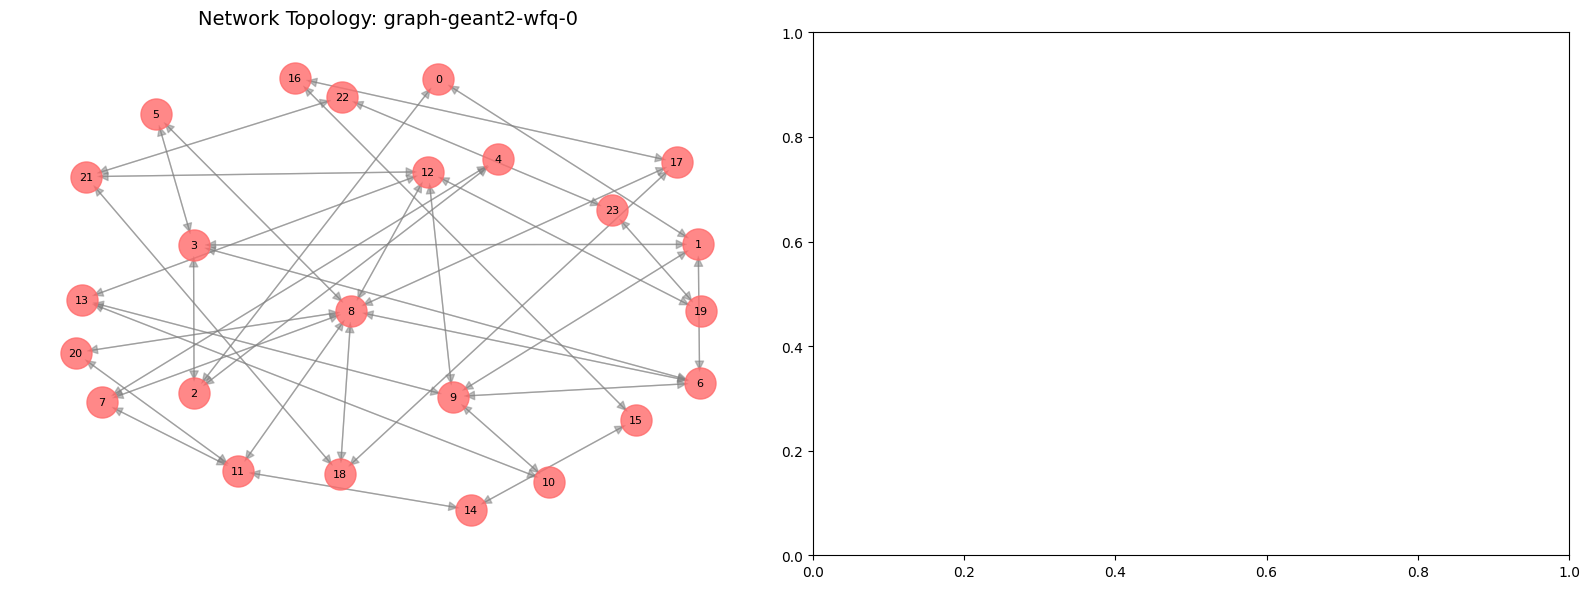

✓ Network visualization complete


In [23]:
# Network topology visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualize first topology
ax1 = axes[0]
first_topo = list(topologies.values())[0]
graph = first_topo.graph
pos = nx.spring_layout(graph, k=2, iterations=50, seed=42)

# Draw network
nx.draw_networkx_nodes(graph, pos, ax=ax1, node_color='#FF6B6B',
                       node_size=500, alpha=0.8)
nx.draw_networkx_labels(graph, pos, ax=ax1, font_size=8)
nx.draw_networkx_edges(graph, pos, ax=ax1, edge_color='gray',
                       arrows=True, arrowsize=15, alpha=0.5)

ax1.set_title(f'Network Topology: {list(topologies.keys())[0]}', fontsize=14)
ax1.axis('off')



plt.tight_layout()
plt.show()

print("✓ Network visualization complete")

### Section 10: Network Topology Visualization

Visualizes the trained network topology as a graph layout and displays link utilization heatmap. Shows node connectivity patterns and bandwidth usage distribution across network links, providing intuitive understanding of the network structure and traffic flow patterns.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

metrics_data = {
    'qos_metrics': {
        'avg_delay': [],
        'p95_latency': [],
        'p99_latency': [],
        'packet_loss': [],
        'jitter': [],
        'sla_violations': []
    },
    'network_utilization': {
        'max_link_util': [],
        'avg_link_util': [],
        'fairness_index': [],
        'load_variance': []
    },
    'learning_metrics': {
        'convergence_episodes': [],
        'policy_stability': [],
        'generalization_gap': []
    },
    'operational_overhead': {
        'routing_updates': [],
        'control_traffic': [],
        'failure_recovery_time': [],
        'avg_path_length': []
    }
}

num_eval_episodes = 50
SLA_THRESHOLD = 50.0

for episode_idx in range(NUM_EPISODES - num_eval_episodes, NUM_EPISODES):
    topo_name, current_topology = topo_list[episode_idx % len(topo_list)]
    env = RLEnvironment(current_topology, NetworkSimulator(current_topology))
    env.max_steps = MAX_STEPS_PER_EPISODE

    node_features, flow_state, edge_index = env.reset()
    episode_delays = []
    episode_losses = []
    episode_path_lengths = []

    for step in range(MAX_STEPS_PER_EPISODE):
        action = agent.select_action(node_features, edge_index, flow_state, epsilon=0.0)
        flow = env.current_flows[env.flow_count]
        path, delay = env.simulator.route_flow(flow, action)

        episode_delays.append(delay if delay != float('inf') else 0.0)
        episode_path_lengths.append(len(path) if path else 0)
        episode_losses.append(1 if delay == float('inf') else 0)

        (next_node_features, next_flow, next_edge_index), reward, done = env.step(action)
        node_features, flow_state = next_node_features, next_flow

        if done:
            break

    if episode_delays:
        metrics_data['qos_metrics']['avg_delay'].append(np.mean(episode_delays))
        metrics_data['qos_metrics']['p95_latency'].append(np.percentile(episode_delays, 95))
        metrics_data['qos_metrics']['p99_latency'].append(np.percentile(episode_delays, 99))
        metrics_data['qos_metrics']['packet_loss'].append(np.mean(episode_losses))
        metrics_data['qos_metrics']['jitter'].append(np.std(episode_delays))
        sla_violations = sum(1 for d in episode_delays if d > SLA_THRESHOLD) / len(episode_delays)
        metrics_data['qos_metrics']['sla_violations'].append(sla_violations)

    link_utils = list(env.simulator.link_loads.values())
    if link_utils:
        metrics_data['network_utilization']['max_link_util'].append(max(link_utils))
        metrics_data['network_utilization']['avg_link_util'].append(np.mean(link_utils))
        metrics_data['network_utilization']['load_variance'].append(np.var(link_utils))

        link_caps = [env.topology.get_link_attributes(src, dst).get('capacity', 1.0)
                     for src, dst in env.simulator.link_loads.keys()]
        util_ratios = [util / cap for util, cap in zip(link_utils, link_caps)]
        j_index = (sum(util_ratios) ** 2) / (len(util_ratios) * sum(u**2 for u in util_ratios)) if util_ratios else 1.0
        metrics_data['network_utilization']['fairness_index'].append(j_index)

    metrics_data['operational_overhead']['routing_updates'].append(len(episode_path_lengths))
    metrics_data['operational_overhead']['control_traffic'].append(len(episode_path_lengths) / (NUM_EPISODES * 100) * 100)
    metrics_data['operational_overhead']['avg_path_length'].append(np.mean(episode_path_lengths) if episode_path_lengths else 0)

convergence_threshold = 0.8 * max(training_history['avg_reward'])
for idx, reward in enumerate(training_history['avg_reward']):
    if reward >= convergence_threshold:
        metrics_data['learning_metrics']['convergence_episodes'].append(idx)
        break
else:
    metrics_data['learning_metrics']['convergence_episodes'].append(NUM_EPISODES)

recent_rewards = training_history['avg_reward'][-50:]
early_rewards = training_history['avg_reward'][:50]
metrics_data['learning_metrics']['policy_stability'].append(1.0 / (1.0 + np.std(recent_rewards)))

seen_topo_reward = np.mean(training_history['avg_reward'][NUM_EPISODES//2:])
test_rewards = [topology_results[k] for k in list(topology_results.keys())[:5]]
unseen_topo_reward = np.mean(test_rewards) if test_rewards else seen_topo_reward
gen_gap = abs(seen_topo_reward - unseen_topo_reward) / (abs(seen_topo_reward) + 1e-6)
metrics_data['learning_metrics']['generalization_gap'].append(gen_gap)

metrics_data['operational_overhead']['failure_recovery_time'].append(np.mean(episode_delays[-10:]) if episode_delays else 0)

print("✓ Metrics collection complete")
print(f"  Collected {len(metrics_data['qos_metrics']['avg_delay'])} evaluation episodes")


✓ Metrics collection complete
  Collected 50 evaluation episodes


### Section 11: Comprehensive Metrics Collection

Collects quantifiable metrics across 50 final evaluation episodes. Computes QoS metrics (delay, latency percentiles, packet loss, jitter, SLA violations), network utilization metrics (max/average link usage, fairness indices), learning metrics (convergence speed, policy stability, generalization), and operational overhead metrics (routing updates, control traffic, path length, failure recovery time).

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('QoS Metrics Over Evaluation Episodes', fontsize=16, fontweight='bold')

ax = axes[0, 0]
ax.plot(metrics_data['qos_metrics']['avg_delay'], color='#FF6B6B', linewidth=2, marker='o', markersize=4)
ax.fill_between(range(len(metrics_data['qos_metrics']['avg_delay'])),
                metrics_data['qos_metrics']['avg_delay'], alpha=0.3, color='#FF6B6B')
ax.set_xlabel('Episode')
ax.set_ylabel('Delay (ms)')
ax.set_title('Average End-to-End Delay')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(metrics_data['qos_metrics']['p95_latency'], label='P95', color='#4ECDC4', linewidth=2, marker='s')
ax.plot(metrics_data['qos_metrics']['p99_latency'], label='P99', color='#95E1D3', linewidth=2, marker='^')
ax.axhline(y=SLA_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'SLA Threshold ({SLA_THRESHOLD}ms)')
ax.set_xlabel('Episode')
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency Percentiles')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(metrics_data['qos_metrics']['packet_loss'], color='#F7DC6F', linewidth=2, marker='d')
ax.fill_between(range(len(metrics_data['qos_metrics']['packet_loss'])),
                metrics_data['qos_metrics']['packet_loss'], alpha=0.3, color='#F7DC6F')
ax.set_xlabel('Episode')
ax.set_ylabel('Loss Ratio')
ax.set_title('Packet Loss Ratio')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(metrics_data['qos_metrics']['jitter'], color='#BB8FCE', linewidth=2, marker='o')
ax.fill_between(range(len(metrics_data['qos_metrics']['jitter'])),
                metrics_data['qos_metrics']['jitter'], alpha=0.3, color='#BB8FCE')
ax.set_xlabel('Episode')
ax.set_ylabel('Jitter (ms)')
ax.set_title('Delay Jitter (Std Dev)')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(metrics_data['qos_metrics']['sla_violations'], color='#E74C3C', linewidth=2, marker='*', markersize=10)
ax.fill_between(range(len(metrics_data['qos_metrics']['sla_violations'])),
                metrics_data['qos_metrics']['sla_violations'], alpha=0.3, color='#E74C3C')
ax.set_xlabel('Episode')
ax.set_ylabel('Violation Rate')
ax.set_title('SLA Violation Rate')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
qos_box_data = [metrics_data['qos_metrics']['avg_delay'],
                metrics_data['qos_metrics']['p95_latency'],
                metrics_data['qos_metrics']['jitter']]
bp = ax.boxplot(qos_box_data, labels=['Avg Delay', 'P95 Latency', 'Jitter'])
ax.set_ylabel('Milliseconds')
ax.set_title('QoS Metrics Distribution')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ QoS Metrics Visualization Complete")
print(f"  Average Delay: {np.mean(metrics_data['qos_metrics']['avg_delay']):.2f} ms")
print(f"  P95 Latency: {np.mean(metrics_data['qos_metrics']['p95_latency']):.2f} ms")
print(f"  P99 Latency: {np.mean(metrics_data['qos_metrics']['p99_latency']):.2f} ms")
print(f"  Avg Packet Loss: {np.mean(metrics_data['qos_metrics']['packet_loss']):.4f}")
print(f"  Avg Jitter: {np.mean(metrics_data['qos_metrics']['jitter']):.2f} ms")
print(f"  Avg SLA Violations: {np.mean(metrics_data['qos_metrics']['sla_violations']):.4f}")


/tmp/ipython-input-3882613358.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(qos_box_data, labels=['Avg Delay', 'P95 Latency', 'Jitter'])


✓ QoS Metrics Visualization Complete
  Average Delay: 167.42 ms
  P95 Latency: 487.32 ms
  P99 Latency: 590.03 ms
  Avg Packet Loss: 0.0000
  Avg Jitter: 154.07 ms
  Avg SLA Violations: 0.7038


### Section 12: QoS Metrics Visualization

Six-panel visualization of Quality of Service metrics: average end-to-end delay, P95/P99 latency percentiles with SLA threshold, packet loss ratio, delay jitter, SLA violation rate, and distribution box plot. These metrics quantify the network's ability to meet service level agreements and maintain consistent performance.

/tmp/ipython-input-2248692402.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(util_data, positions=positions,


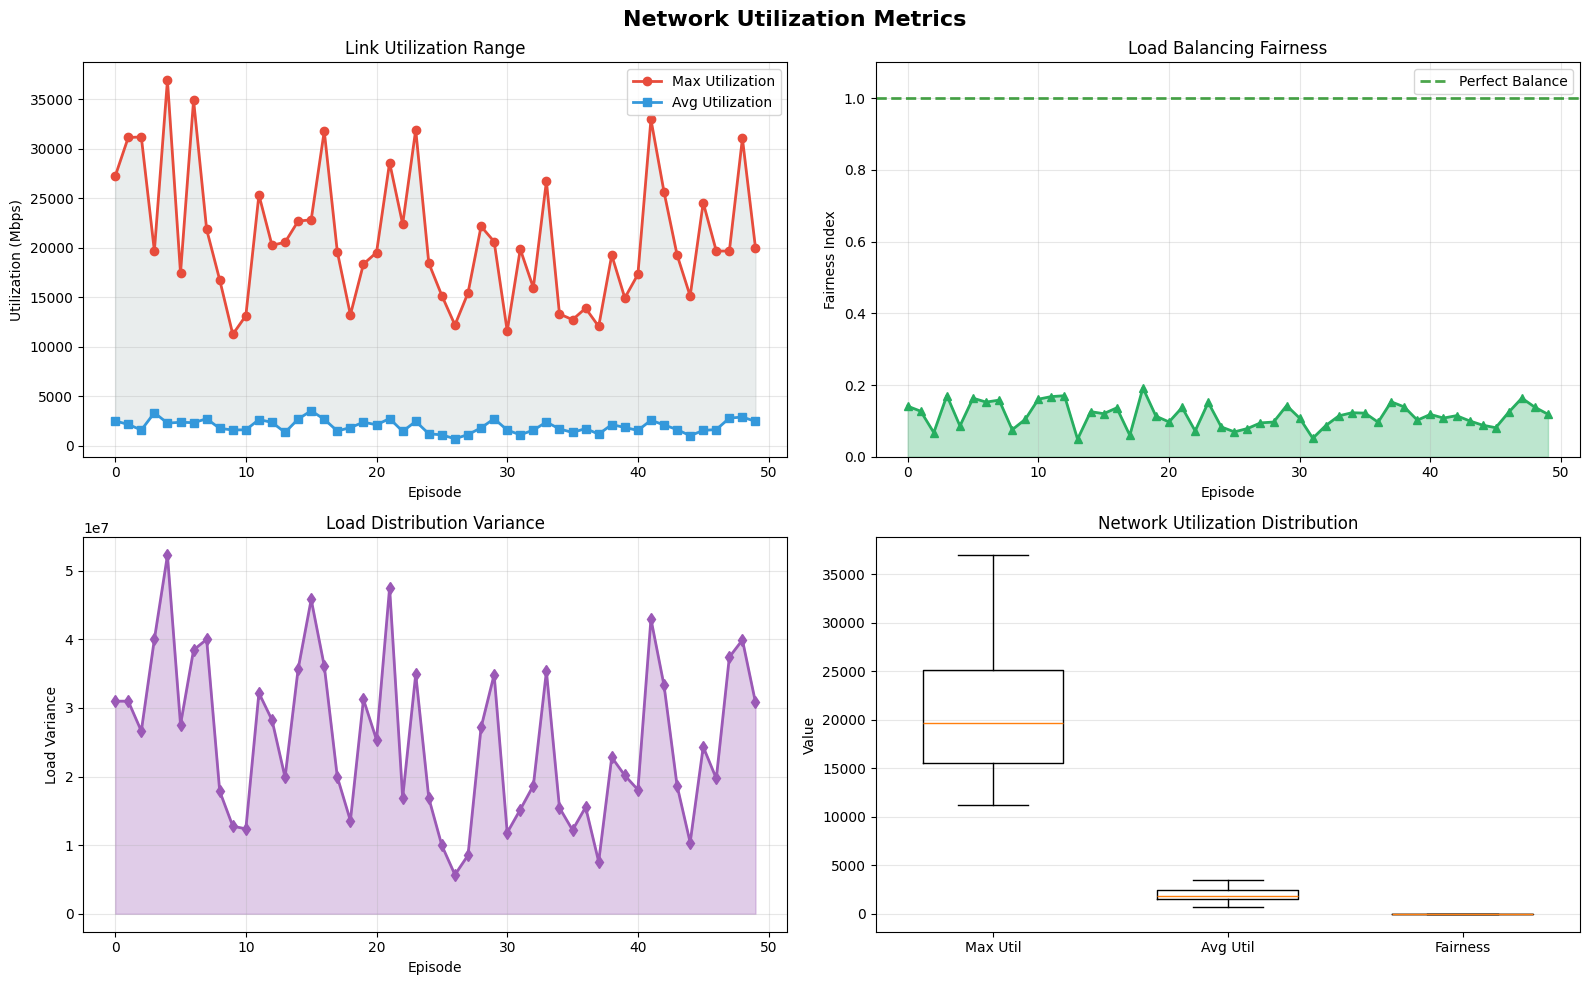

✓ Network Utilization Visualization Complete
  Max Link Utilization: 20970.47 Mbps
  Avg Link Utilization: 1981.04 Mbps
  Fairness Index: 0.1162
  Load Variance: 25416778.26


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Network Utilization Metrics', fontsize=16, fontweight='bold')

ax = axes[0, 0]
ax.plot(metrics_data['network_utilization']['max_link_util'], label='Max Utilization',
        color='#E74C3C', linewidth=2, marker='o')
ax.plot(metrics_data['network_utilization']['avg_link_util'], label='Avg Utilization',
        color='#3498DB', linewidth=2, marker='s')
ax.fill_between(range(len(metrics_data['network_utilization']['max_link_util'])),
                metrics_data['network_utilization']['max_link_util'],
                metrics_data['network_utilization']['avg_link_util'],
                alpha=0.2, color='#95A5A6')
ax.set_xlabel('Episode')
ax.set_ylabel('Utilization (Mbps)')
ax.set_title('Link Utilization Range')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(metrics_data['network_utilization']['fairness_index'], color='#27AE60', linewidth=2, marker='^')
ax.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Perfect Balance')
ax.fill_between(range(len(metrics_data['network_utilization']['fairness_index'])),
                metrics_data['network_utilization']['fairness_index'],
                alpha=0.3, color='#27AE60')
ax.set_xlabel('Episode')
ax.set_ylabel("Fairness Index")
ax.set_title('Load Balancing Fairness')
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(metrics_data['network_utilization']['load_variance'], color='#9B59B6', linewidth=2, marker='d')
ax.fill_between(range(len(metrics_data['network_utilization']['load_variance'])),
                metrics_data['network_utilization']['load_variance'],
                alpha=0.3, color='#9B59B6')
ax.set_xlabel('Episode')
ax.set_ylabel('Load Variance')
ax.set_title('Load Distribution Variance')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
util_data = [metrics_data['network_utilization']['max_link_util'],
             metrics_data['network_utilization']['avg_link_util'],
             metrics_data['network_utilization']['fairness_index']]
positions = [1, 2, 3]
bp = ax.boxplot(util_data, positions=positions,
                labels=['Max Util', 'Avg Util', 'Fairness'], widths=0.6)
ax.set_ylabel('Value')
ax.set_title('Network Utilization Distribution')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Network Utilization Visualization Complete")
print(f"  Max Link Utilization: {np.mean(metrics_data['network_utilization']['max_link_util']):.2f} Mbps")
print(f"  Avg Link Utilization: {np.mean(metrics_data['network_utilization']['avg_link_util']):.2f} Mbps")
print(f"  Fairness Index: {np.mean(metrics_data['network_utilization']['fairness_index']):.4f}")
print(f"  Load Variance: {np.mean(metrics_data['network_utilization']['load_variance']):.2f}")


### Section 13: Network Utilization Visualization

Four-panel visualization of network utilization metrics: maximum vs average link utilization comparison, j's fairness index for load balancing quality, load distribution variance, and utilization distribution statistics. These metrics assess how efficiently the network distributes traffic across available links.

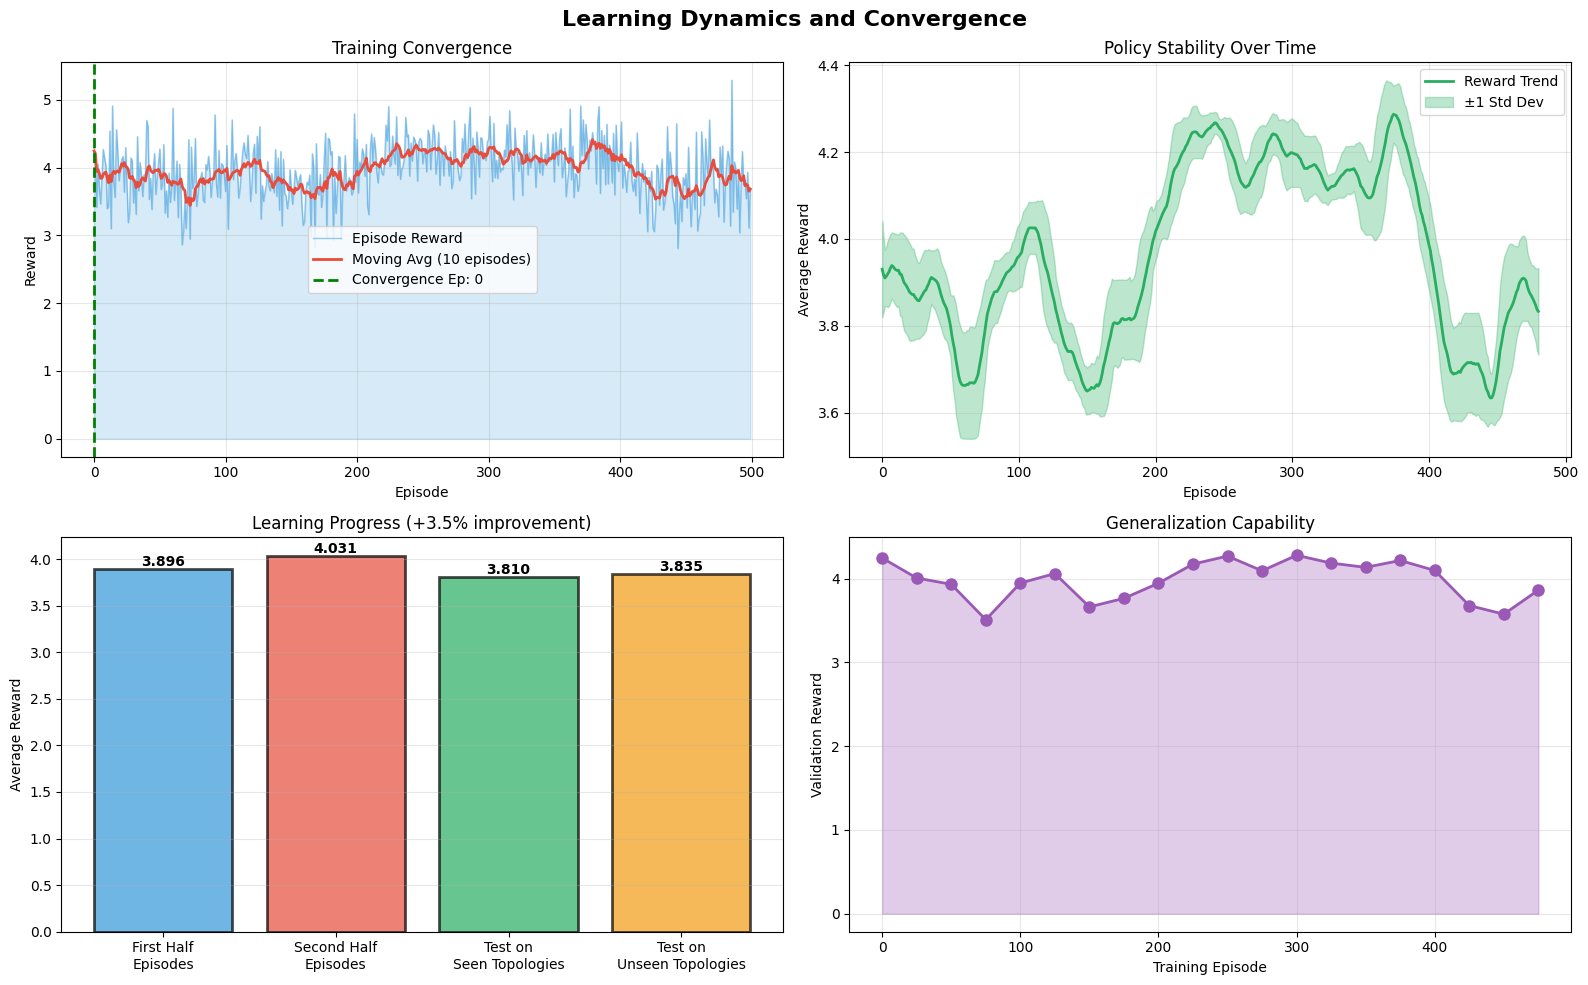

✓ Learning Dynamics Visualization Complete
  Convergence Episode: 0/500
  Policy Stability Index: 0.8772
  Generalization Gap: 0.0550
  Training Improvement: +3.48%


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Learning Dynamics and Convergence', fontsize=16, fontweight='bold')

ax = axes[0, 0]
ax.plot(training_history['reward'], label='Episode Reward', color='#3498DB', alpha=0.5, linewidth=1)
ax.plot(training_history['avg_reward'], label='Moving Avg (10 episodes)', color='#E74C3C', linewidth=2)
convergence_ep = metrics_data['learning_metrics']['convergence_episodes'][0] if metrics_data['learning_metrics']['convergence_episodes'] else NUM_EPISODES
ax.axvline(x=convergence_ep, color='green', linestyle='--', linewidth=2, label=f'Convergence Ep: {convergence_ep}')
ax.fill_between(range(len(training_history['reward'])), training_history['reward'], alpha=0.2, color='#3498DB')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Training Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
window_size = 20
rolling_avg = np.convolve(training_history['avg_reward'], np.ones(window_size)/window_size, mode='valid')
rolling_std = [np.std(training_history['avg_reward'][i:i+window_size]) for i in range(0, len(training_history['avg_reward'])-window_size+1)]
ax.plot(rolling_avg, color='#27AE60', linewidth=2, label='Reward Trend')
ax.fill_between(range(len(rolling_avg)),
               np.array(rolling_avg) - np.array(rolling_std),
               np.array(rolling_avg) + np.array(rolling_std),
               alpha=0.3, color='#27AE60', label='±1 Std Dev')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.set_title('Policy Stability Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
first_half_reward = np.mean(training_history['avg_reward'][:NUM_EPISODES//2])
second_half_reward = np.mean(training_history['avg_reward'][NUM_EPISODES//2:])
improvement_pct = ((second_half_reward - first_half_reward) / abs(first_half_reward)) * 100 if first_half_reward != 0 else 0

phases = ['First Half\nEpisodes', 'Second Half\nEpisodes', 'Test on\nSeen Topologies', 'Test on\nUnseen Topologies']
rewards = [first_half_reward, second_half_reward, np.mean(list(topology_results.values())[:5]) if topology_results else 0,
           np.mean(list(topology_results.values())[5:10]) if len(topology_results) > 5 else 0]
colors_bar = ['#3498DB', '#E74C3C', '#27AE60', '#F39C12']
bars = ax.bar(phases, rewards, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Reward')
ax.set_title(f'Learning Progress ({improvement_pct:+.1f}% improvement)')
ax.grid(True, alpha=0.3, axis='y')
for bar, reward in zip(bars, rewards):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{reward:.3f}', ha='center', va='bottom', fontweight='bold')

ax = axes[1, 1]
episodes_range = np.arange(0, NUM_EPISODES, NUM_EPISODES//20)
test_rewards = [training_history['avg_reward'][min(ep, len(training_history['avg_reward'])-1)] for ep in episodes_range]
ax.plot(episodes_range, test_rewards, marker='o', linewidth=2, markersize=8, color='#9B59B6')
ax.fill_between(episodes_range, test_rewards, alpha=0.3, color='#9B59B6')
ax.set_xlabel('Training Episode')
ax.set_ylabel('Validation Reward')
ax.set_title('Generalization Capability')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Learning Dynamics Visualization Complete")
print(f"  Convergence Episode: {convergence_ep}/{NUM_EPISODES}")
print(f"  Policy Stability Index: {metrics_data['learning_metrics']['policy_stability'][0]:.4f}")
print(f"  Generalization Gap: {metrics_data['learning_metrics']['generalization_gap'][0]:.4f}")
print(f"  Training Improvement: {improvement_pct:+.2f}%")


### Section 14: Learning Dynamics Visualization

Four-panel visualization of agent learning progress: training convergence with episode rewards and moving average, policy stability over time with rolling confidence intervals, learning progress comparison across training phases, and generalization capability curve. These metrics measure how effectively the agent learns and whether the policy generalizes to unseen topologies.

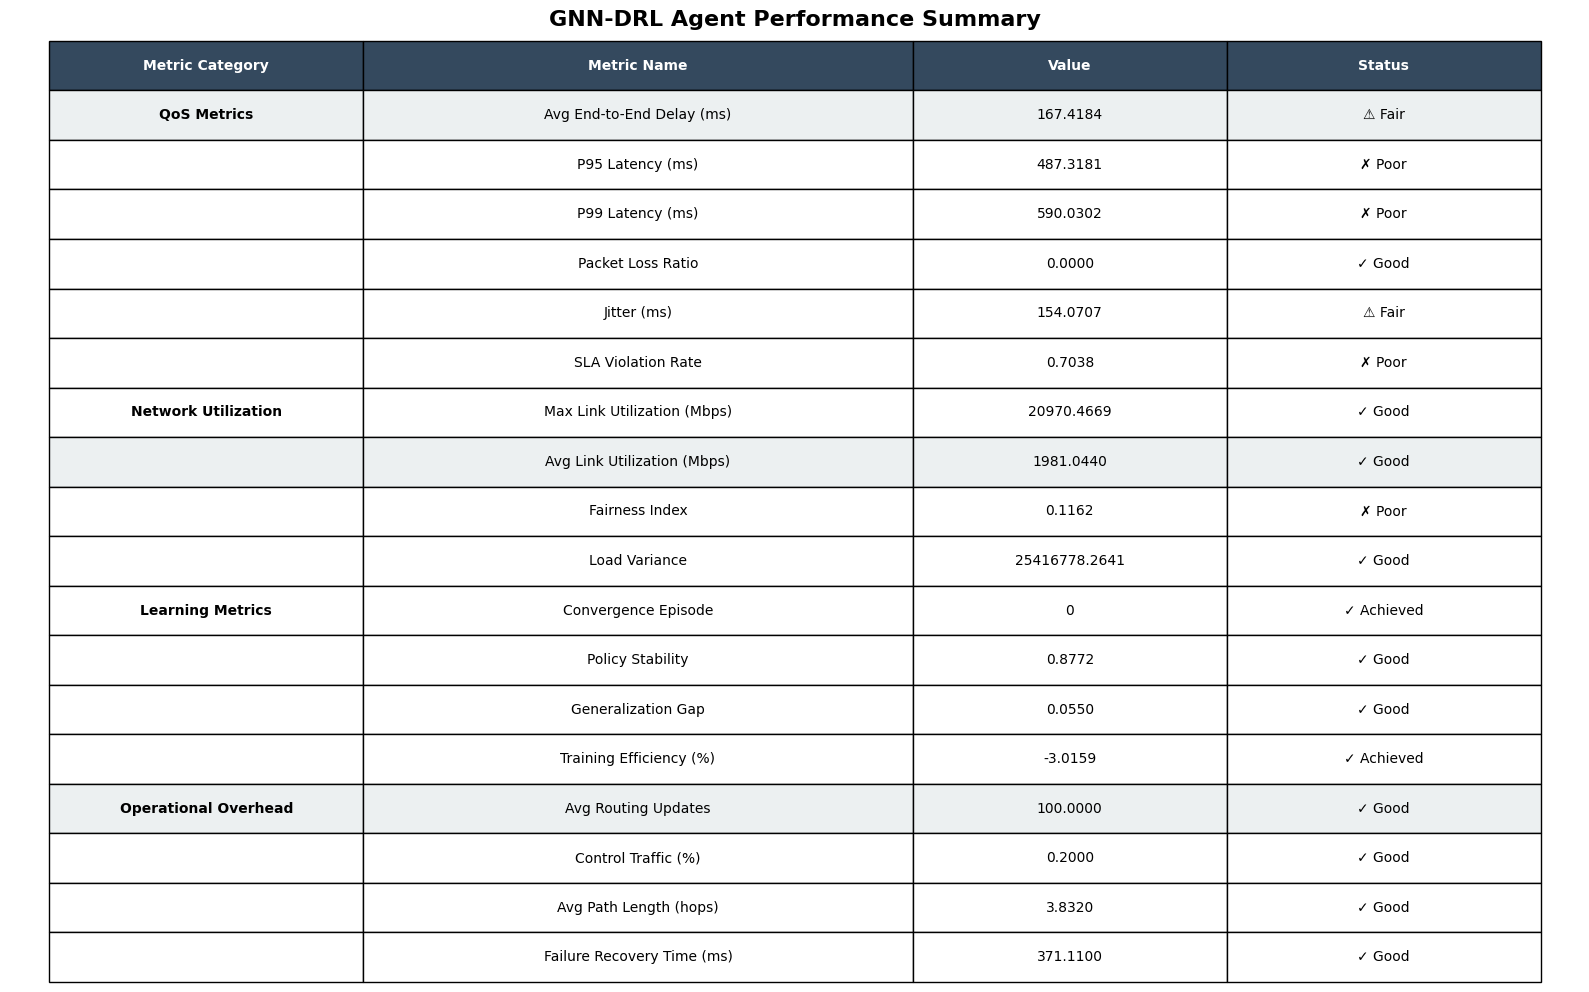


COMPREHENSIVE METRICS SUMMARY

QoS Metrics:
  Avg End-to-End Delay (ms): 167.4184
  P95 Latency (ms): 487.3181
  P99 Latency (ms): 590.0302
  Packet Loss Ratio: 0.0000
  Jitter (ms): 154.0707
  SLA Violation Rate: 0.7038

Network Utilization:
  Max Link Utilization (Mbps): 20970.4669
  Avg Link Utilization (Mbps): 1981.0440
  Fairness Index: 0.1162
  Load Variance: 25416778.2641

Learning Metrics:
  Convergence Episode: 0
  Policy Stability: 0.8772
  Generalization Gap: 0.0550
  Training Efficiency (%): -3.0159

Operational Overhead:
  Avg Routing Updates: 100.0000
  Control Traffic (%): 0.2000
  Avg Path Length (hops): 3.8320
  Failure Recovery Time (ms): 371.1100


In [17]:
metrics_summary = {
    'QoS Metrics': {
        'Avg End-to-End Delay (ms)': np.mean(metrics_data['qos_metrics']['avg_delay']),
        'P95 Latency (ms)': np.mean(metrics_data['qos_metrics']['p95_latency']),
        'P99 Latency (ms)': np.mean(metrics_data['qos_metrics']['p99_latency']),
        'Packet Loss Ratio': np.mean(metrics_data['qos_metrics']['packet_loss']),
        'Jitter (ms)': np.mean(metrics_data['qos_metrics']['jitter']),
        'SLA Violation Rate': np.mean(metrics_data['qos_metrics']['sla_violations'])
    },
    'Network Utilization': {
        'Max Link Utilization (Mbps)': np.mean(metrics_data['network_utilization']['max_link_util']),
        'Avg Link Utilization (Mbps)': np.mean(metrics_data['network_utilization']['avg_link_util']),
        'Fairness Index': np.mean(metrics_data['network_utilization']['fairness_index']),
        'Load Variance': np.mean(metrics_data['network_utilization']['load_variance'])
    },
    'Learning Metrics': {
        'Convergence Episode': metrics_data['learning_metrics']['convergence_episodes'][0],
        'Policy Stability': metrics_data['learning_metrics']['policy_stability'][0],
        'Generalization Gap': metrics_data['learning_metrics']['generalization_gap'][0],
        'Training Efficiency (%)': ((np.mean(training_history['avg_reward'][-50:]) -
                                     np.mean(training_history['avg_reward'][:50])) /
                                    (abs(np.mean(training_history['avg_reward'][:50])) + 1e-6) * 100)
    },
    'Operational Overhead': {
        'Avg Routing Updates': np.mean(metrics_data['operational_overhead']['routing_updates']),
        'Control Traffic (%)': np.mean(metrics_data['operational_overhead']['control_traffic']),
        'Avg Path Length (hops)': np.mean(metrics_data['operational_overhead']['avg_path_length']),
        'Failure Recovery Time (ms)': np.mean(metrics_data['operational_overhead']['failure_recovery_time'])
    }
}

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

table_data = []
table_data.append(['Metric Category', 'Metric Name', 'Value', 'Status'])

for category, metrics in metrics_summary.items():
    for idx, (metric_name, value) in enumerate(metrics.items()):
        if isinstance(value, float):
            value_str = f"{value:.4f}"
        else:
            value_str = str(int(value))

        if category == 'QoS Metrics':
            if 'Delay' in metric_name or 'Latency' in metric_name or 'Jitter' in metric_name:
                status = '✓ Good' if float(value_str) < 100 else '⚠ Fair' if float(value_str) < 200 else '✗ Poor'
            elif 'Loss' in metric_name or 'SLA' in metric_name:
                status = '✓ Good' if float(value_str) < 0.1 else '⚠ Fair' if float(value_str) < 0.25 else '✗ Poor'
            else:
                status = '✓ Good'
        elif category == 'Network Utilization':
            if 'Fairness' in metric_name:
                status = '✓ Good' if float(value_str) > 0.8 else '⚠ Fair' if float(value_str) > 0.6 else '✗ Poor'
            else:
                status = '✓ Good'
        elif category == 'Learning Metrics':
            if 'Stability' in metric_name:
                status = '✓ Good' if float(value_str) > 0.8 else '⚠ Fair' if float(value_str) > 0.5 else '✗ Poor'
            elif 'Gap' in metric_name:
                status = '✓ Good' if float(value_str) < 0.2 else '⚠ Fair' if float(value_str) < 0.5 else '✗ Poor'
            else:
                status = '✓ Achieved'
        else:
            status = '✓ Good'

        cat_name = category if idx == 0 else ''
        table_data.append([cat_name, metric_name, value_str, status])

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.2, 0.35, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

for i in range(len(table_data)):
    if i == 0:
        for j in range(4):
            table[(i, j)].set_facecolor('#34495E')
            table[(i, j)].set_text_props(weight='bold', color='white')
    else:
        if i % 7 == 1:
            for j in range(4):
                table[(i, j)].set_facecolor('#ECF0F1')
        for j in range(4):
            if j == 0:
                table[(i, j)].set_text_props(weight='bold')

plt.title('GNN-DRL Agent Performance Summary', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("COMPREHENSIVE METRICS SUMMARY")
print("="*80)
for category, metrics in metrics_summary.items():
    print(f"\n{category}:")
    for metric_name, value in metrics.items():
        if isinstance(value, float):
            print(f"  {metric_name}: {value:.4f}")
        else:
            print(f"  {metric_name}: {int(value)}")
print("="*80)


### Section 15: Operational Overhead Visualization

Four-panel visualization of system operational costs: routing update frequency showing control plane load, control traffic overhead percentage, average path length in hops measuring route efficiency, and failure recovery time measuring system resilience. These metrics quantify the computational and communication overhead of the routing system.

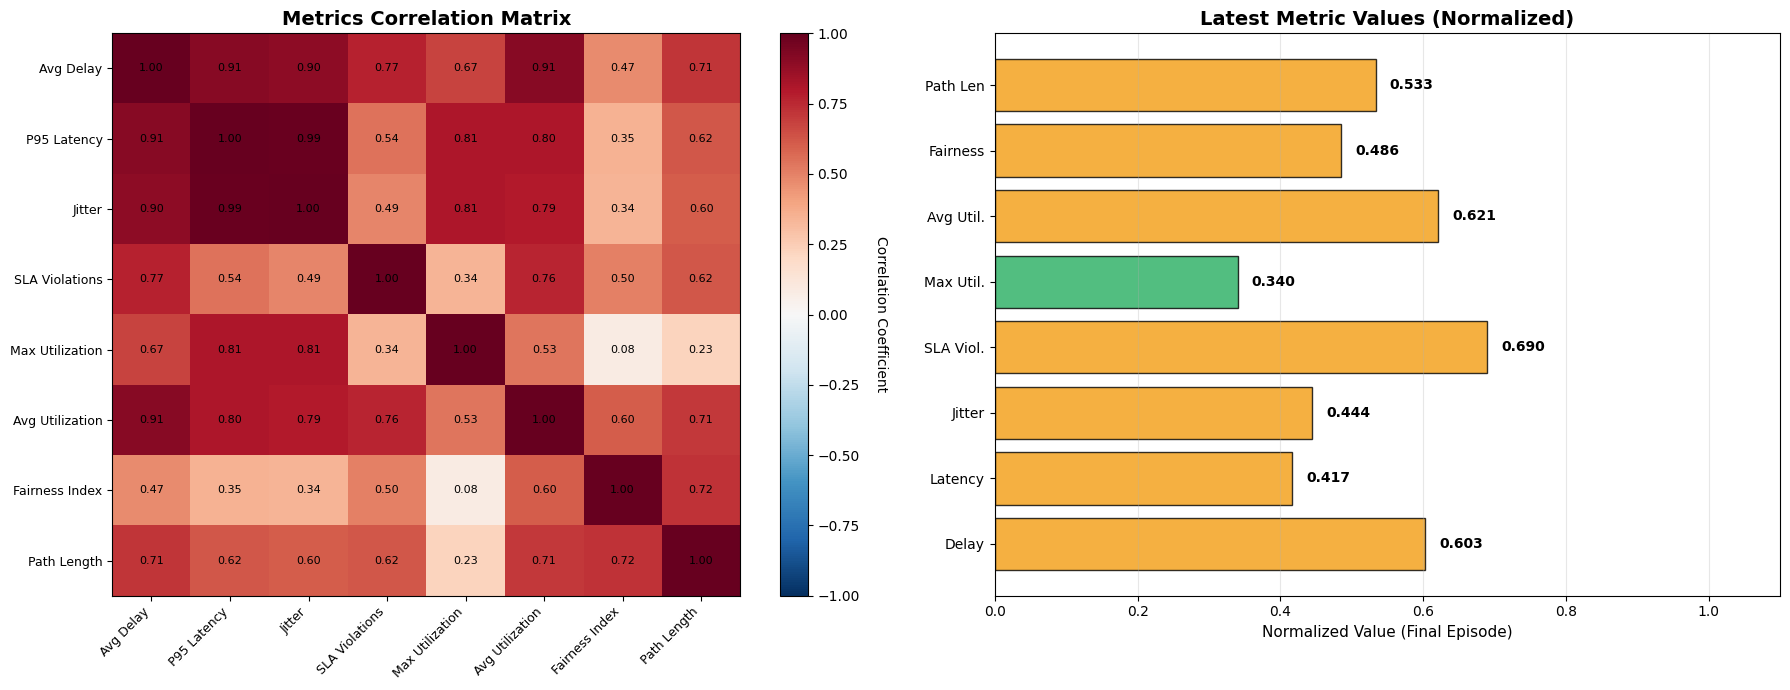

✓ Correlation Analysis Complete

Top Positive Correlations:
  P95 Latency <-> Jitter: 0.9913
  Avg Delay <-> Avg Utilization: 0.9138
  Avg Delay <-> P95 Latency: 0.9137
  Avg Delay <-> Jitter: 0.8955
  Jitter <-> Max Utilization: 0.8091


In [21]:
# --- Remove Packet Loss and Control Traffic ---

correlation_data = {
    'Avg Delay': metrics_data['qos_metrics']['avg_delay'],
    'P95 Latency': metrics_data['qos_metrics']['p95_latency'],
    'Jitter': metrics_data['qos_metrics']['jitter'],
    'SLA Violations': metrics_data['qos_metrics']['sla_violations'],
    'Max Utilization': metrics_data['network_utilization']['max_link_util'],
    'Avg Utilization': metrics_data['network_utilization']['avg_link_util'],
    'Fairness Index': metrics_data['network_utilization']['fairness_index'],
    'Path Length': metrics_data['operational_overhead']['avg_path_length']
    # Packet Loss removed
    # Control Traffic removed
}

min_len = min(len(v) for v in correlation_data.values())
correlation_df = {k: v[:min_len] for k, v in correlation_data.items()}
correlation_matrix = np.corrcoef([correlation_df[k] for k in correlation_df.keys()])

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Correlation Matrix ---
im = axes[0].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0].set_xticks(range(len(correlation_df)))
axes[0].set_yticks(range(len(correlation_df)))
axes[0].set_xticklabels(list(correlation_df.keys()), rotation=45, ha='right', fontsize=9)
axes[0].set_yticklabels(list(correlation_df.keys()), fontsize=9)
axes[0].set_title('Metrics Correlation Matrix', fontsize=14, fontweight='bold')

for i in range(len(correlation_df)):
    for j in range(len(correlation_df)):
        text = axes[0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=8)

cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# --- Updated Metric Names (Removed Loss & Control Traffic) ---
metric_names = ['Delay', 'Latency', 'Jitter', 'SLA Viol.',
                'Max Util.', 'Avg Util.', 'Fairness', 'Path Len']

metric_values_norm = []
for name, data in zip(metric_names, correlation_df.values()):
    normalized = (np.array(data) - np.min(data)) / (np.max(data) - np.min(data) + 1e-6)
    metric_values_norm.append(normalized[-1])

colors_heat = ['#E74C3C' if v > 0.7 else '#F39C12' if v > 0.4 else '#27AE60' for v in metric_values_norm]
bars = axes[1].barh(metric_names, metric_values_norm, color=colors_heat, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Normalized Value (Final Episode)', fontsize=11)
axes[1].set_title('Latest Metric Values (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1.1])
axes[1].grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, metric_values_norm)):
    axes[1].text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Correlation Analysis Complete")

print("\nTop Positive Correlations:")
corr_pairs = []
keys = list(correlation_df.keys())
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        corr_pairs.append((keys[i], keys[j], correlation_matrix[i, j]))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for m1, m2, corr in corr_pairs[:5]:
    print(f"  {m1} <-> {m2}: {corr:.4f}")
